# Grover Search Algorithm Example

We implement a permutation
\begin{align*}
    (0~~2) =
    \begin{pmatrix}
        0 & 1 & 2 & 3 \\
        2 & 1 & 0 & 3
    \end{pmatrix}
\end{align*}
on a quantum circuit with $4+4$ qubits:
\begin{align*}
    & f\colon x_3x_2x_1x_0 \mapsto x_3x_0x_1x_2, \quad x_0,x_1,x_2,x_3\in\{0,1\},\\[.5em]
    & U_f\colon |x_3x_2x_1x_0\rangle|0000\rangle \mapsto |x_3x_2x_1x_0\rangle|f(x_3x_2x_1x_0)\rangle.
\end{align*}
In what follows, we assume that the function $f$ implemented on the circuit is not explicitly defined, i.e., the gate $U_f$ is treated as an oracle.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile
from qiskit.circuit.library import XGate, GroverOperator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_distribution
import numpy as np
import copy

In [2]:
backend = AerSimulator()

The oracle $U_f$ is as follows.

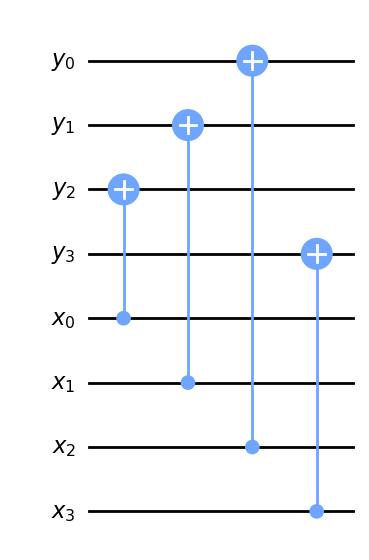

In [3]:
N = 4
nx_qubits, ny_qubits = N, N
qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qc = QuantumCircuit(qr_y, qr_x)

# |x3>|x2>|x1>|x0>|0000> -> |x3>|x2>|x1>|x0>|x3>|x0>|x1>|x2>
for i in range(nx_qubits):
    qc.cx(i + ny_qubits, (ny_qubits - 2 - i) % ny_qubits)

Uf = qc.to_gate()
Uf.name = '   $U_f$   '
qc.draw('mpl')

In [4]:
nx_qubits, ny_qubits = N, N
qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qc = QuantumCircuit(qr_y, qr_x)

# |x3>|x2>|x1>|x0>|0000> -> |x3>|x2>|x1>|x0>|x3>|x0>|x1>|x2>
for i in range(nx_qubits):
    qc.h(i + ny_qubits)

qc.append(Uf, qargs=range(ny_qubits + nx_qubits))
U_prep = qc.to_gate()
U_prep.name = '$U_{prep}$'

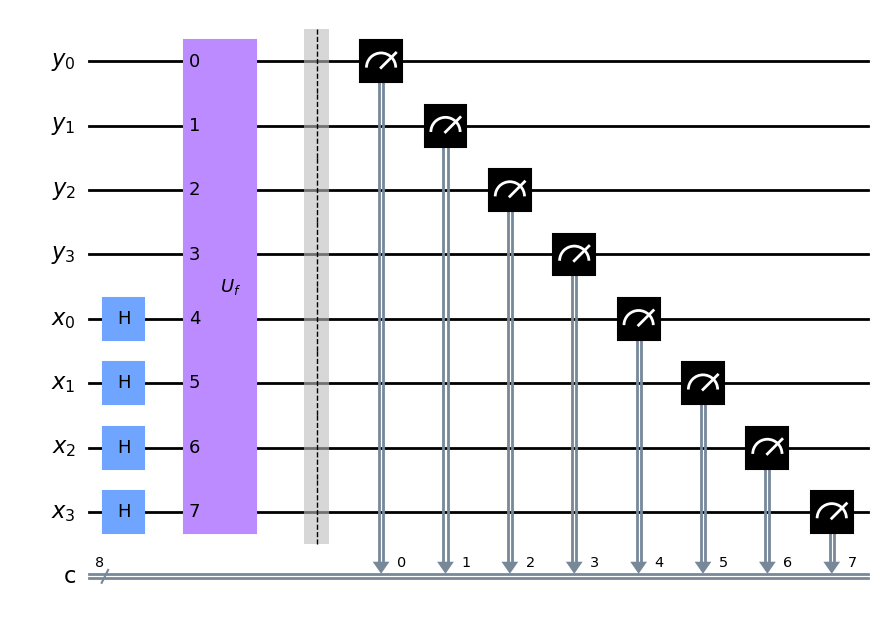

In [5]:
nx_qubits, ny_qubits = N, N
qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qc = QuantumCircuit(qr_y, qr_x)

qc.append(U_prep, qargs=range(ny_qubits + nx_qubits))

qc.barrier()
cr = ClassicalRegister(nx_qubits + ny_qubits, 'c')
qc.add_register(cr)
qc.measure(list(range(nx_qubits + ny_qubits)), cr)
qc.decompose().draw('mpl')

{'00000000': 624, '10101010': 634, '10111110': 630, '00010100': 623, '10011100': 655, '11011101': 612, '11111111': 635, '10001000': 618, '11001001': 632, '01110111': 587, '00110110': 618, '01000001': 637, '11101011': 613, '01010101': 592, '00100010': 667, '01100011': 623}


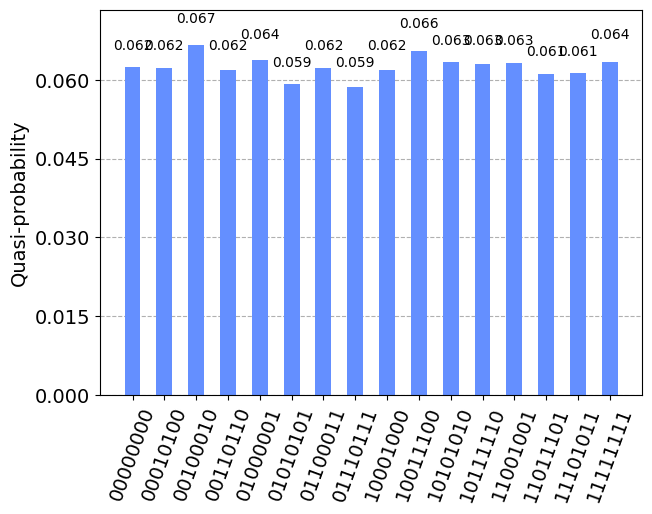

In [6]:
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_distribution(counts)

As an example, we search for a bitstring where $f$ attains $0011$.
We introduce an additional ancilla qubit No. 0 ("marker"), and flip it to $|1\rangle$ when $f$ takes the value $0011$.
The circuit diagram for this is as follows.

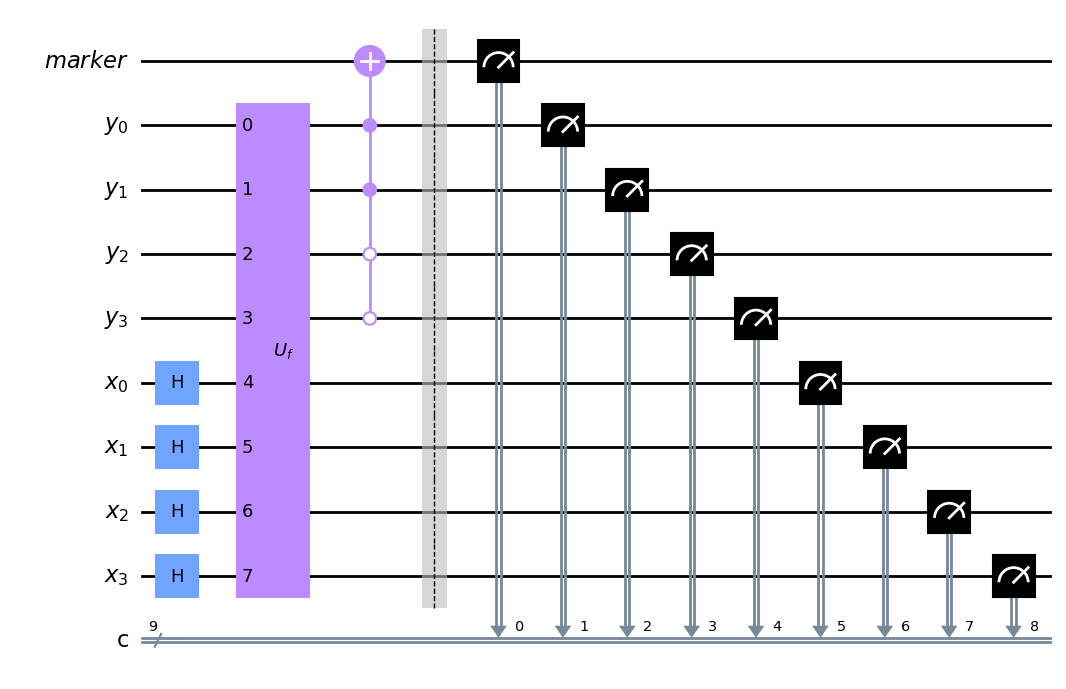

In [7]:
target = '0011'
n_markers = 1
qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qr_marker = QuantumRegister(n_markers, 'marker')
qc = QuantumCircuit(qr_marker, qr_y, qr_x)

# preparing state
qc.append(U_prep, qargs=range(n_markers, n_markers + ny_qubits + nx_qubits))

# marking on the qubit "marker"
c4x_gate = XGate().control(ny_qubits, ctrl_state=target)
qargs_marking = list(range(n_markers, n_markers + ny_qubits)) + [0]
qc.append(c4x_gate, qargs=qargs_marking)

qc.barrier()
cr = ClassicalRegister(n_markers + nx_qubits + ny_qubits, 'c')
qc.add_register(cr)
qc.measure(range(qc.num_qubits), cr)

qc.decompose(gates_to_decompose='$U_{prep}$').draw('mpl')

{'011101110': 647, '011000111': 588, '000000000': 571, '010000010': 624, '100010000': 637, '001000100': 631, '111010110': 623, '101111100': 611, '001101100': 645, '111111110': 628, '000101000': 637, '010101010': 637, '101010100': 668, '110010010': 635, '110111010': 620, '100111000': 598}


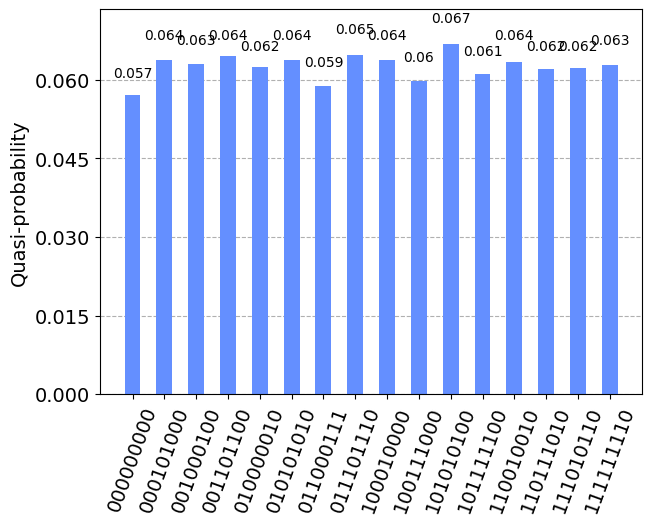

In [8]:
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_distribution(counts)

As can be seen from the histgram above, we observe that qubit No. 0 takes the state $|1\rangle$ when $|f(x_3x_2x_1x_0)\rangle$ equals $|0011\rangle$.

In the following, we set a Grover operator $Q$ for this problem.
The state preparation gate is the same as the one used above, and is as follows:

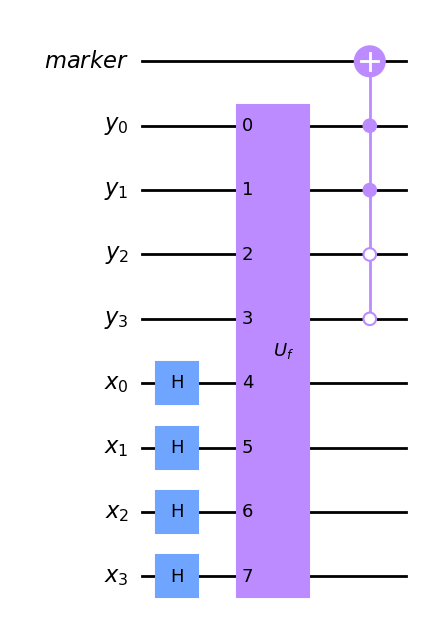

In [9]:
qr_x = QuantumRegister(nx_qubits, 'x')
qr_y = QuantumRegister(nx_qubits, 'y')
qr_marker = QuantumRegister(n_markers, 'marker')
qc = QuantumCircuit(qr_marker, qr_y, qr_x)

# preparing state
qc.append(U_prep, qargs=range(n_markers, n_markers + ny_qubits + nx_qubits))

# marking on the qubit "marker"
c4x_gate = XGate().control(ny_qubits, ctrl_state=target)
qargs_marking = list(range(n_markers, n_markers + ny_qubits)) + [0]
qc.append(c4x_gate, qargs=qargs_marking)

qc.decompose(gates_to_decompose='$U_{prep}$').draw('mpl')

Set a Grover operator $Q$.

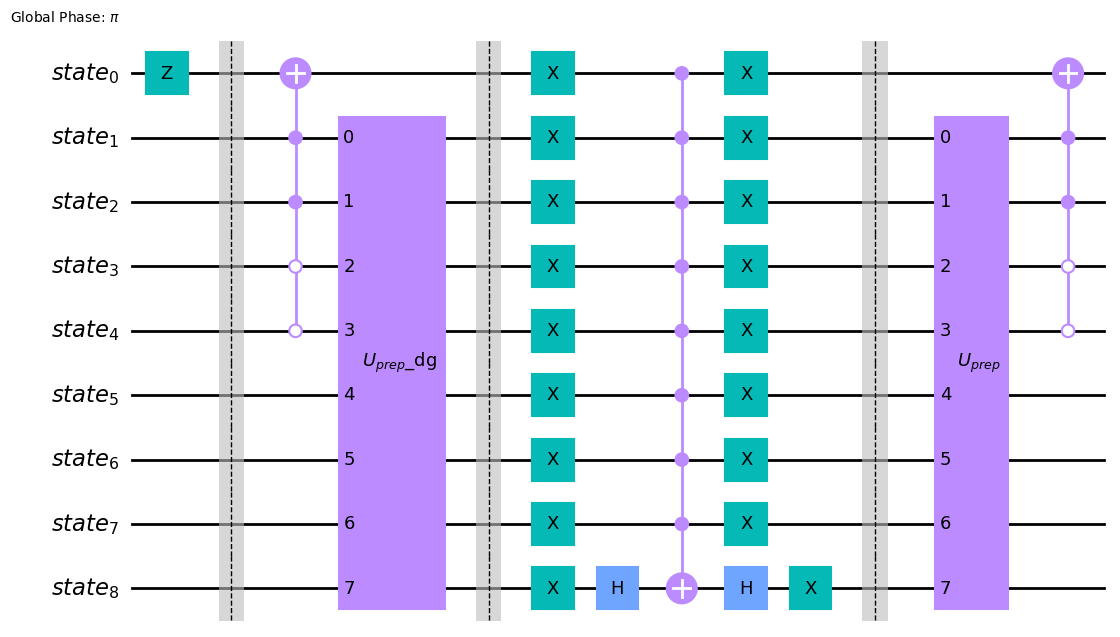

In [10]:
oracle = QuantumCircuit(n_markers + nx_qubits + ny_qubits)
oracle.z(0)
Q = GroverOperator(oracle, state_preparation=qc, insert_barriers=True)
Q.decompose().draw('mpl')

The number of iterations for $Q$ is $\lfloor \pi/(4\arcsin \sqrt{2^{-4}}) \rfloor=3$ since the probability of  observing $|0011\rangle$ is $1/2^4$.

number of iterations: 3


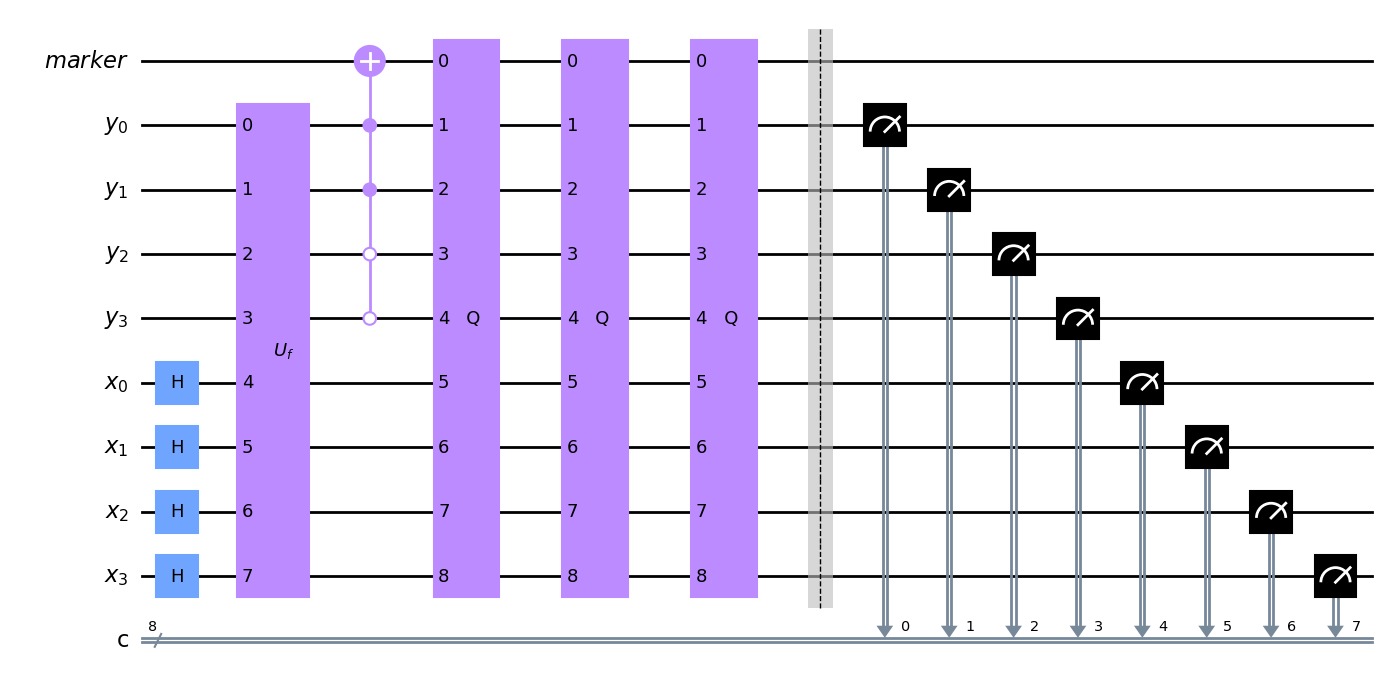

In [11]:
_qc = copy.deepcopy(qc)
n_iter = int(np.floor(np.pi / 4 / np.arcsin(np.sqrt(1 / 2 ** nx_qubits))))
print(f'number of iterations: {n_iter}')

Q = GroverOperator(oracle, state_preparation=qc, insert_barriers=False)
Q.name = '   Q   '

for i in range(n_iter):
    _qc.append(Q.to_gate(), qargs=range(n_markers + nx_qubits + ny_qubits))

_qc.barrier()
cr = ClassicalRegister(nx_qubits + ny_qubits, 'c')
_qc.add_register(cr)
_qc.measure([1, 2, 3, 4, 5, 6, 7, 8], cr)

_qc.decompose(gates_to_decompose='$U_{prep}$').draw('mpl')

{'11101011': 23, '01100011': 9624, '00110110': 25, '11001001': 27, '01010101': 31, '10101010': 26, '00100010': 25, '11111111': 14, '10001000': 18, '10011100': 31, '11011101': 24, '01000001': 22, '00010100': 36, '10111110': 25, '01110111': 27, '00000000': 22}


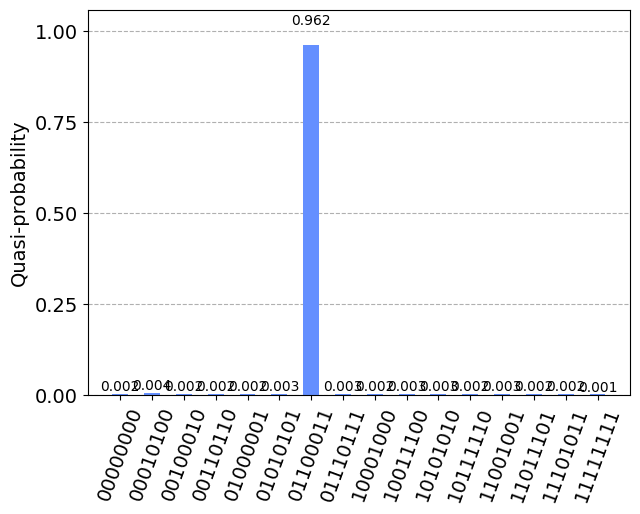

In [12]:
qc_compiled = transpile(_qc, backend)
job_sim = backend.run(qc_compiled, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_distribution(counts)

We can see that the probability of observing $|f(x_3x_2x_1x_0)\rangle=|0011\rangle$ has been increased, and as a result, we can get $x=0110$ as the answer for satisfying $f(x)=0011$.